C:\Users\YERNI KUMAR\.conda\envs\open_cv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


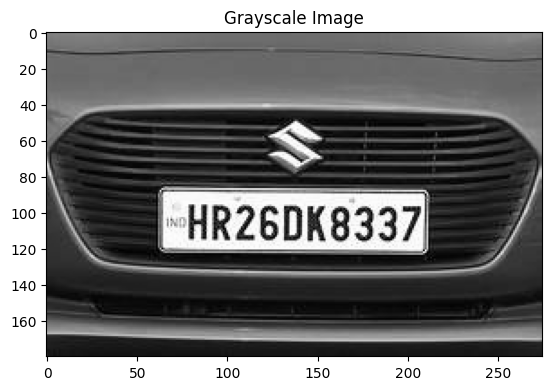

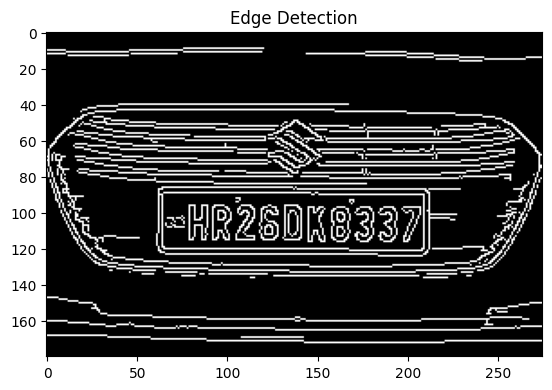

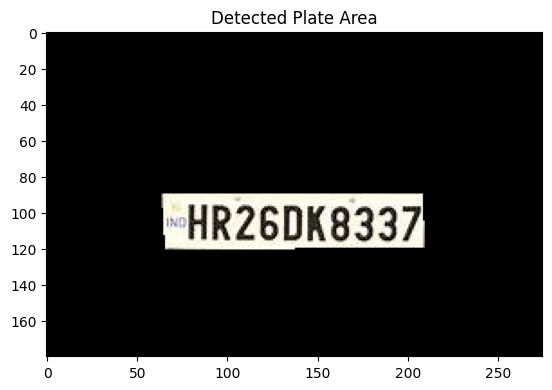

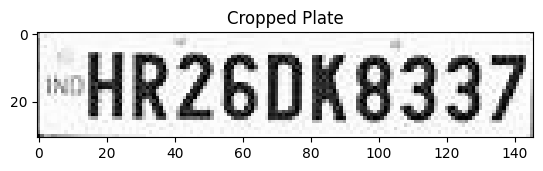

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Detected Number Plate: HRZGDK8337


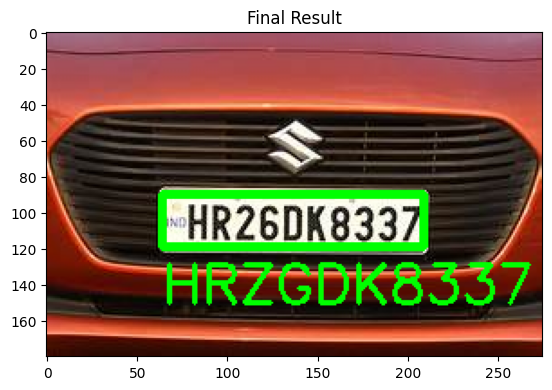

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils
import easyocr

# Load the image
image_path = r"C:\Users\YERNI KUMAR\Downloads\th (13).jpg"
img = cv2.imread(image_path)
if img is None:
    print(f"Could not read the image from {image_path}")
    exit()

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))
plt.title("Grayscale Image")
plt.show()

# Apply bilateral filter to reduce noise
bfilter = cv2.bilateralFilter(gray, 11, 17, 17)
edged = cv2.Canny(bfilter, 30, 200)
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))
plt.title("Edge Detection")
plt.show()

# Find contours in the edged image
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

# Initialize location variable
location = None

# Loop through contours to find the best approximated polygon for the plate
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len(approx) == 4:
        location = approx
        break

# Create a mask for the number plate
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [location], 0, 255, -1)
new_image = cv2.bitwise_and(img, img, mask=mask)
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))
plt.title("Detected Plate Area")
plt.show()

# Extract the coordinates of the number plate
(x, y) = np.where(mask == 255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))

# Crop the plate area from the grayscale image
cropped_image = gray[x1:x2+1, y1:y2+1]
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
plt.title("Cropped Plate")
plt.show()

# Use EasyOCR to read text from the cropped image
reader = easyocr.Reader(['en'])
result = reader.readtext(cropped_image)

# Print the result
if result:
    print("Detected Number Plate:", result[0][1])
    text = result[0][1]
    
    # Annotate the image with the detected text
    font = cv2.FONT_HERSHEY_SIMPLEX
    res = cv2.putText(img, text=text, org=(approx[0][0][0], approx[1][0][1]+60), 
                      fontFace=font, fontScale=1, color=(0, 255, 0), thickness=2)
    res = cv2.rectangle(img, tuple(approx[0][0]), tuple(approx[2][0]), (0, 255, 0), 3)
    plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
    plt.title("Final Result")
    plt.show()
else:
    print("No number plate detected in the image.")
